In [23]:
import sys
'geopandas' in sys.modules
import urllib.request
import json 
import matplotlib.pyplot as plt
import numpy as np
import dateutil.parser
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import pandas as pd
from datetime import date, timedelta

In [2]:
url_reg='https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json'

with urllib.request.urlopen(url_reg) as response:
    html = response.read()
    
data_reg = json.loads(html)

In [3]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province.json'

with urllib.request.urlopen(url) as response:
    html = response.read()
    
data = json.loads(html)

In [4]:
print(data_reg[0])

{'data': '2020-02-24T18:00:00', 'stato': 'ITA', 'codice_regione': 13, 'denominazione_regione': 'Abruzzo', 'lat': 42.35122196, 'long': 13.39843823, 'ricoverati_con_sintomi': 0, 'terapia_intensiva': 0, 'totale_ospedalizzati': 0, 'isolamento_domiciliare': 0, 'totale_positivi': 0, 'variazione_totale_positivi': 0, 'nuovi_positivi': 0, 'dimessi_guariti': 0, 'deceduti': 0, 'casi_da_sospetto_diagnostico': None, 'casi_da_screening': None, 'totale_casi': 0, 'tamponi': 5, 'casi_testati': None, 'note': None, 'ingressi_terapia_intensiva': None, 'note_test': None, 'note_casi': None, 'totale_positivi_test_molecolare': None, 'totale_positivi_test_antigenico_rapido': None, 'tamponi_test_molecolare': None, 'tamponi_test_antigenico_rapido': None, 'codice_nuts_1': None, 'codice_nuts_2': None}


In [5]:
print(data[0])

{'data': '2020-02-24T18:00:00', 'stato': 'ITA', 'codice_regione': 13, 'denominazione_regione': 'Abruzzo', 'codice_provincia': 66, 'denominazione_provincia': "L'Aquila", 'sigla_provincia': 'AQ', 'lat': 42.35122196, 'long': 13.39843823, 'totale_casi': 0, 'note': None, 'codice_nuts_1': None, 'codice_nuts_2': None, 'codice_nuts_3': None}


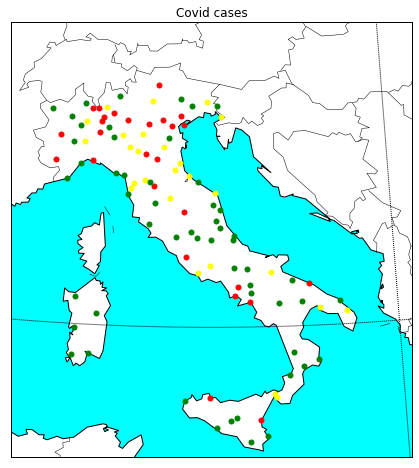

In [24]:
# setup lambert conformal basemap.
# lat_1 is first standard parallel.
# lat_2 is second standard parallel (defaults to lat_1).
# lon_0,lat_0 is central point.
# rsphere=(6378137.00,6356752.3142) specifies WGS84 ellipsoid
# area_thresh=1000 means don't plot coastline features less
# than 1000 km^2 in area.
fig = plt.figure(figsize=(8, 8))
m = Basemap(width=1200000,height=1300000,
            resolution='l',area_thresh=1000.,projection='lcc',\
            lat_0=data[0]['lat'], lon_0=data[0]['long'],)
m.drawcoastlines()
m.fillcontinents(color='white',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='aqua')
m.drawcountries()
# draw tissot's indicatrix to show distortion.
ax = plt.gca()


today = (date.today() - timedelta(days=1)).strftime("%Y-%m-%d")

arr = []
for row in data:
    if not today in row['data'] or row['long'] is None or row['lat'] is None:
        continue
    arr.append(row['totale_casi'])

green, yellow, red = np.percentile(arr,[25,50,75])
    
def get_color(value):
    if(value > red):
        return 'red'
    if(value > yellow):
        return 'yellow'
    return 'green'
    
for row in data:
    if not today in row['data'] or row['long'] is None or row['lat'] is None:
        continue
    x, y = m(row['long'], row['lat'])
    plt.plot(x, y, 'o', markersize=5, color=get_color(row['totale_casi']))
    #plt.text(x, y, row['denominazione_provincia'], fontsize=12)

plt.title("Covid cases")
plt.show()

In [7]:
italy = gpd.read_file('italian-maps-shapefiles-master/italy-with-regions/reg2011_g.shp')
new_regions = pd.read_csv('italian-maps-shapefiles-master/italy-with-regions/reg2011_g.csv')

In [8]:
italy['NOME_REG'] = new_regions['NOME_REG']
italy.head()

,COD_REG,NOME_REG,SHAPE_Leng,SHAPE_Area,geometry
0,1,Piemonte,1.236869e+06,2.539410e+10,"POLYGON ((457832.312 5145701.000, 458745.249 5..."
1,2,Valle d'Aosta,3.111651e+05,3.259041e+09,"POLYGON ((390734.999 5091965.001, 390830.999 5..."
2,3,Lombardia,1.411265e+06,2.386270e+10,"MULTIPOLYGON (((595736.187 5163715.001, 596126..."
3,4,Trentino,8.005341e+05,1.360802e+10,"POLYGON ((743386.080 5219948.900, 743472.190 5..."
4,5,Veneto,1.057856e+06,1.840550e+10,"POLYGON ((768209.001 5175597.001, 768220.251 5..."


In [25]:
dataframe = [];
acc = 0;


today_region = (date.today() - timedelta(days=1)).strftime("%Y-%m-%d")
field = 'terapia_intensiva'
for row in data_reg:
    if not today_region in row['data'] or row['long'] is None or row['lat'] is None:
        continue
    if 'P.A.' in row['denominazione_regione']:
        acc += row[field]
    else:
        dataframe.append([row['denominazione_regione'],row[field]])
    
dataframe.append(['Trentino',acc])

df = pd.DataFrame(dataframe,columns=['NOME_REG', today_region])
df.head

<bound method NDFrame.head of                  NOME_REG  2022-01-09
0                 Abruzzo          27
1              Basilicata           2
2                Calabria          34
3                Campania          76
4          Emilia-Romagna         147
5   Friuli Venezia Giulia          37
6                   Lazio         194
7                 Liguria          46
8               Lombardia         244
9                  Marche          54
10                 Molise           2
11               Piemonte         145
12                 Puglia          40
13               Sardegna          25
14                Sicilia         138
15                Toscana         115
16                 Umbria          13
17          Valle d'Aosta           6
18                 Veneto         206
19               Trentino          44>

<AxesSubplot:title={'center':'2022-01-09'}>

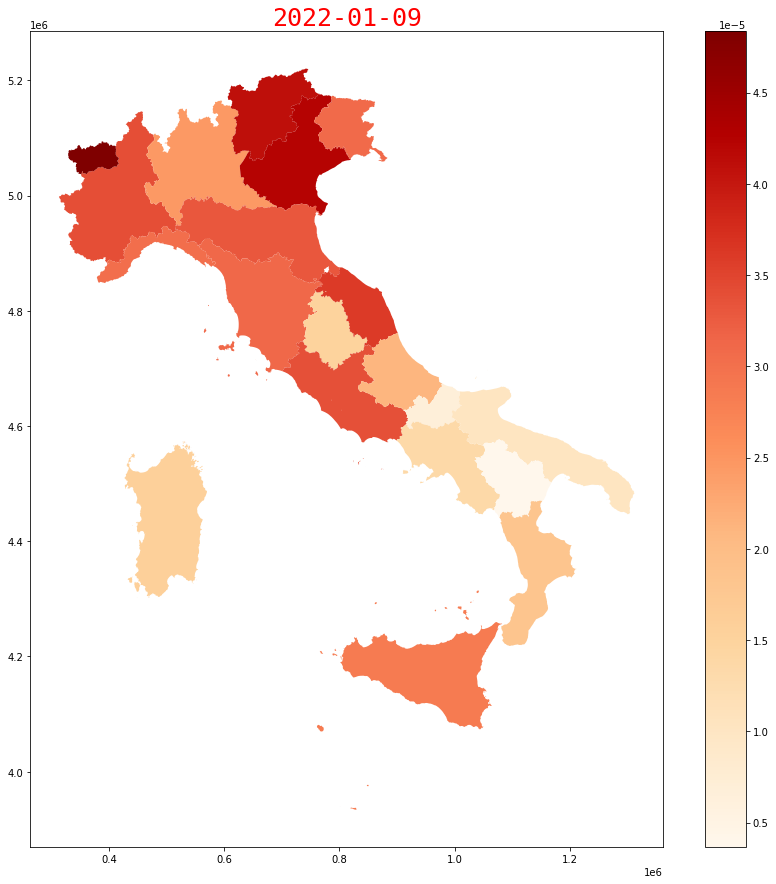

In [26]:
merge = italy.merge(df, on='NOME_REG', how='right')
merge = merge.merge(new_regions, on='NOME_REG', how='right')

merge[today_region] = merge[today_region] / merge['CITIZEN']

fig, ax = plt.subplots(1, figsize=(15, 15))
col = today_region
ax.set_title(col, fontdict={'fontsize':'25', 'fontweight':'3'}, color='Red', fontfamily='monospace')
merge.plot(ax=ax,
           column=col,
           cmap='OrRd',
           label='ciao',
           legend=True,
           categorical=False)

In [11]:
group = {}

field = 'terapia_intensiva'
regione_comune = 'Trentino'

for row in data_reg:
    day = row['data'].split('T')[0]
    if day not in group:
        group[day] = {}
    if 'P.A.' in row['denominazione_regione']:
        if regione_comune not in group[day]:
            group[day][regione_comune] = 0;
        group[day][regione_comune] += row[field];
    else:
        group[day][row['denominazione_regione']] = row[field]

In [12]:
print(group['2020-02-24'])

{'Abruzzo': 0, 'Basilicata': 0, 'Calabria': 0, 'Campania': 0, 'Emilia-Romagna': 2, 'Friuli Venezia Giulia': 0, 'Lazio': 1, 'Liguria': 0, 'Lombardia': 19, 'Marche': 0, 'Molise': 0, 'Trentino': 0, 'Piemonte': 0, 'Puglia': 0, 'Sardegna': 0, 'Sicilia': 0, 'Toscana': 0, 'Umbria': 0, "Valle d'Aosta": 0, 'Veneto': 4}


In [13]:
for day in group:
    # remove next break to run this script that generate a huge output!
    break;
    dataframe = []
    for region in group[day]:
        #print([region, group[day][region]])
        dataframe.append([region, group[day][region]])
    df = pd.DataFrame(dataframe, columns=['NOME_REG', day])
    
    merge = italy.merge(df, on='NOME_REG', how='right')
    merge = merge.merge(new_regions, on='NOME_REG', how='right')

    merge[day] = merge[day] / merge['CITIZEN']

    fig, ax = plt.subplots(1, figsize=(15, 15))
    col = day
    ax.set_title(col, fontdict={'fontsize':'25', 'fontweight':'3'}, color='Red', fontfamily='monospace')
    merge.plot(ax=ax, column=col, cmap='OrRd', label='ciao', legend=True, categorical=False)
    plt.savefig('output_region/'+day+'.jpg')

In [14]:
s = '';
for day in group:
    s += 'file ' + day + '.jpg\n'
    
f = open("output_region/file.txt", "a")
f.write(s)
f.close()

In [15]:
#!cd output_region && ffmpeg -f concat -safe 0 -i file.txt -c copy merged.mp4